In [2]:
import os
import sys
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import contextily as cx
import geopandas as gpd
from matplotlib import colors
import matplotlib.pyplot as plt
from shapely.geometry import Point

# Load and transform neighbourhoods

In [3]:
# Determine which neighbourhoods to keep
# ijburg_buurten = ['M35','M50','M51']  #'M34'
# regstr = '|'.join(ijburg_buurten)
# neighbourhoods = neighbourhoods[neighbourhoods.Buurtcombinatie_code.str.contains(regstr)]
neighbourhoods = gpd.read_file('amsterdam/buurten-geojson_lnglat.php.json').to_crs("epsg:3857")

TopologyException: side location conflict at 541147.64347977156 6859732.213908378. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 543404.94400628982 6866414.1155474968. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 544830.53851299977 6867789.3175093811. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 547350.25124242436 6868686.0745189236. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 552325.82788630272 6854135.9447212564. This can occur if the input geometry is invalid.
TopologyException: side location conflict at 552793.73906589695 6869381.9940214027. This can occur if the input geometry is invalid.


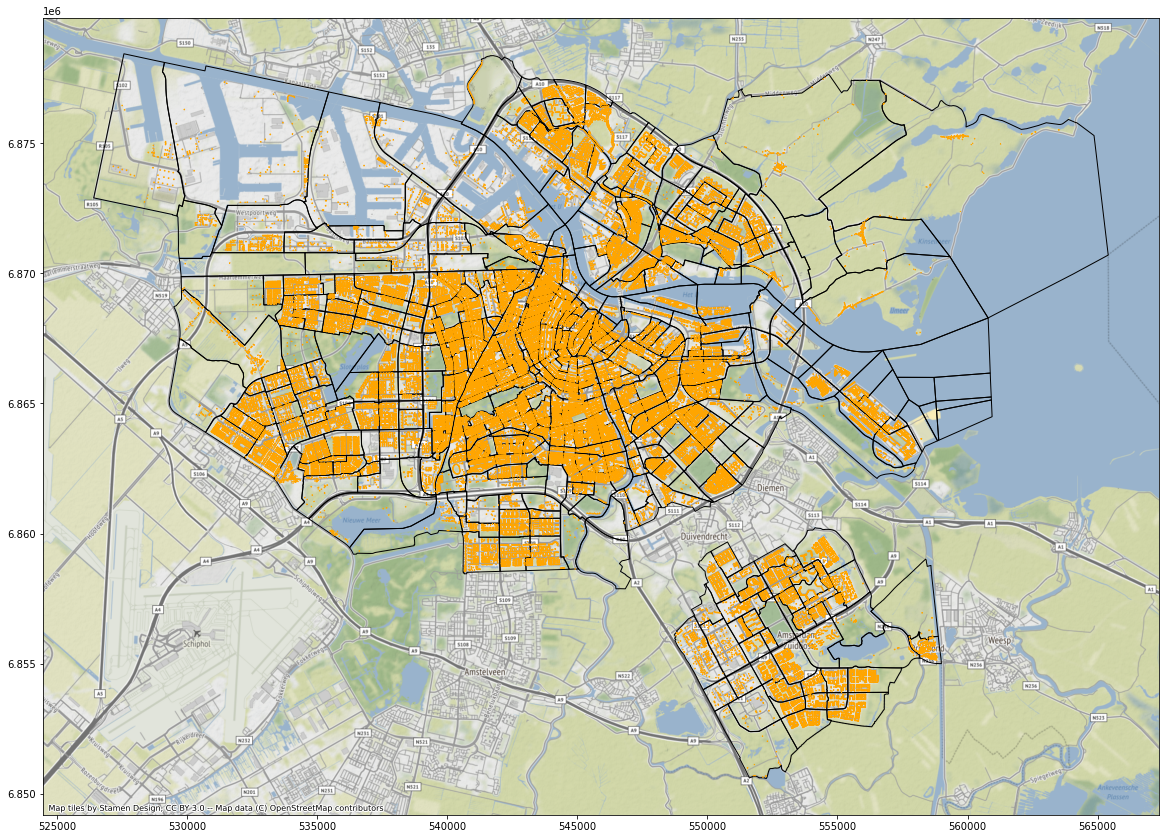

In [4]:
# Import pc6 to avoid people living in water, etc.
pc6 = gpd.read_file('amsterdam/pc6-geojson_lnglat.php.json').to_crs("epsg:3857")
for index, block in pc6.iterrows():
    try:
        if not neighbourhoods.geometry.contains(block.geometry).any():
            pc6.drop(index, inplace=True)
    except:
        pc6.drop(index, inplace=True)
        
fig, ax = plt.subplots(1, 1, figsize=(20, 20))
neighbourhoods.geometry.boundary.plot(
    color=None, edgecolor='k', 
    linewidth=1, ax=ax, zorder=1)
pc6.geometry.boundary.plot(
    color=None, edgecolor='orange', 
    linewidth=1, ax=ax, zorder=2)
cx.add_basemap(ax)

In [5]:
neighbourhood_frame = gpd.GeoDataFrame(neighbourhoods[['Buurt_code', 'geometry']])

# Shape and size follow from the polygons but are needed for schools and households
neighbourhood_frame['shape'] = None
neighbourhood_frame['size'] = None
neighbourhood_frame['color'] = 'black'
neighbourhood_frame.head()

,Buurt_code,geometry,shape,size,color
0,F81d,"POLYGON ((534422.723 6864602.193, 535341.554 6...",None,None,black
1,F81e,"POLYGON ((536402.206 6865029.427, 536406.547 6...",None,None,black
2,F82a,"POLYGON ((532848.220 6865976.022, 533813.249 6...",None,None,black
3,F82b,"POLYGON ((533030.339 6865433.535, 533990.358 6...",None,None,black
4,F82c,"POLYGON ((533243.627 6864790.290, 534250.957 6...",None,None,black


# Load school locations

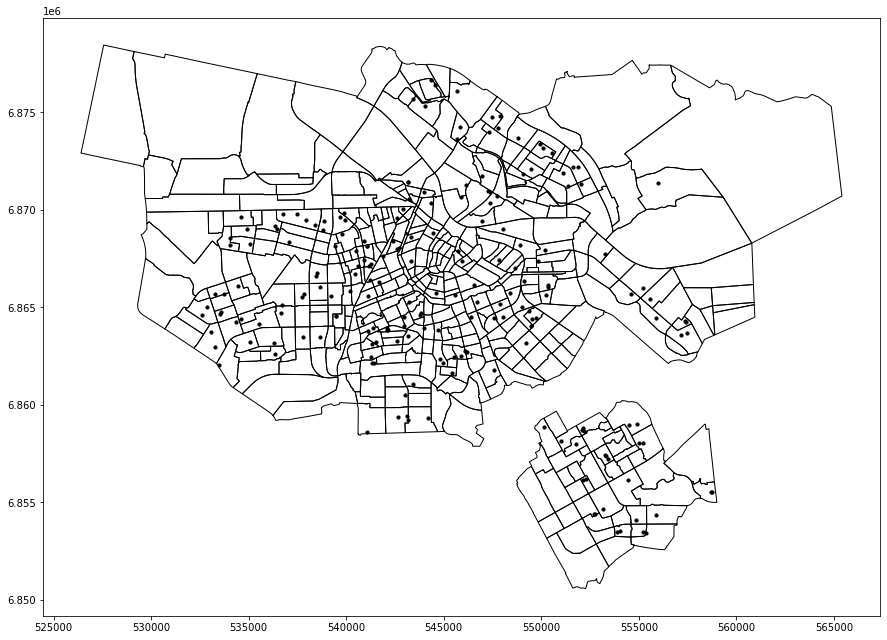

In [6]:
school_frame = gpd.read_file('amsterdam/school_locations.geojson')
school_frame['Buurt_code'] = None
school_frame['shape'] = 'circle'
school_frame['size'] = 5
school_frame['color'] = 'black'
school_frame.drop(columns='address', inplace=True)
school_frame = school_frame.to_crs('EPSG:3857')
school_frame = school_frame[~school_frame.geometry.isna()]

# only keep schools that fall within the polygons
polygons = neighbourhoods.geometry
for index, school in school_frame.iterrows(): # 
    if polygons.contains(school.geometry).any():
        continue
    else:
        school_frame.drop(index, inplace=True)


fig, ax = plt.subplots(1, 1, figsize=(15, 15))
neighbourhoods.geometry.boundary.plot(
    color=None, edgecolor='k', 
    linewidth=1, ax=ax, zorder=1)
_ = school_frame.plot(ax=ax, color='black', markersize=10)

In [7]:
def random_point(minx, miny, maxx, maxy, polygon):
    count = 0
    max_count = 1000
    while count < max_count:
        pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
        if polygon.contains(pnt):
            return pnt
        count += 1

def random_sample(number, polygon, pc6):
    """
    Generates random points within a polygon object
    
    Args:
        number (int): the number of points to sample
        polygon: polygon object from a GeoDataFrame
        
    Returns:
        list of randomly sampled points
    """
    index = 0
    points = [0]*number
    areas = pc6[pc6.within(polygon)]
    
    # Check if there is pc6 geometry available for this multipolygon
    minx, miny, maxx, maxy = polygon.bounds
    if len(areas) < 1: 
        points = [random_point(minx, miny, maxx, maxy, polygon) for _ in range(number)]
        
    else:
        while index < number:
            pnt = random_point(minx, miny, maxx, maxy, polygon)
            if np.any(areas.contains(pnt)):
                points[index] = pnt
                index += 1
    
    return points

# Import BBGA data from the municipality and create households

In [10]:
groups = pd.read_excel('amsterdam/bbga2022.xlsx')
groups = groups[groups['jaar']==2019]

In [20]:
indices = []
perc_of_actual = 1.2
household_frame = gpd.GeoDataFrame()

i = 0
for index, neighbourhood in tqdm(neighbourhood_frame.iterrows(), total=len(neighbourhood_frame)):
    
    if neighbourhood.geometry.type=='MultiPolygon':
        print("The Bokeh visualisation cannot work with multipolygons yet.")
        continue
        
    area = neighbourhood.Buurt_code
    stats = groups[groups['gebiedcode15']==area]

    if stats['BEV4_12'].values >= 10:
        total = int(stats['BEV4_12']*perc_of_actual)
    else:
        indices.append(index)
        continue

    # share is based on people until 17, actual number is based on 4-12 year olds
    no_migration = (stats['BEV17AUTO_P'] / 100).values[0]
    non_western_migration =  (stats['BEV17NW_P'] / 100).values[0] 

#     income = stats[['IINKQ1_P', 'IINKQ2_P', 'IINKQ4_P', 'IINKQ5_P']].fillna(0)
#     low_income = ((income['IINKQ1_P'] + income['IINKQ2_P']) / 100).values[0]
#     low_income = (income['IINKQ1_P'] / 100).values[0]
#     high_income = ((income['IINKQ4_P'] + income['IINKQ5_P']) / 100).values[0]
#     high_income = (income['IINKQ5_P'] / 100).values[0]

#     education = stats[['BEVOPLLAAG_P', 'BEVOPLHOOG_P']].fillna(0)
#     high_ed = (education['BEVOPLHOOG_P'] / 100).values[0]
#     low_ed = (education['BEVOPLLAAG_P'] / 100).values[0]

    group1 = int(total*no_migration)
    group2 = int(total*non_western_migration)

    locations = random_sample(group1+group2, neighbourhood.geometry, pc6)
    households = gpd.GeoDataFrame(geometry=locations) 
    households['group'] = [0]*group1 + [1]*group2
    households['shape'] = 'circle'
    households['size'] = 3
    households['color'] = ['red']*group1 + ['blue']*group2
    households['neighbourhood_id'] = i
    household_frame = pd.concat([household_frame, households])
    i += 1

neighbourhood_frame.drop(index=indices, inplace=True)

100%|██████████| 382/382 [03:10<00:00,  2.00it/s]


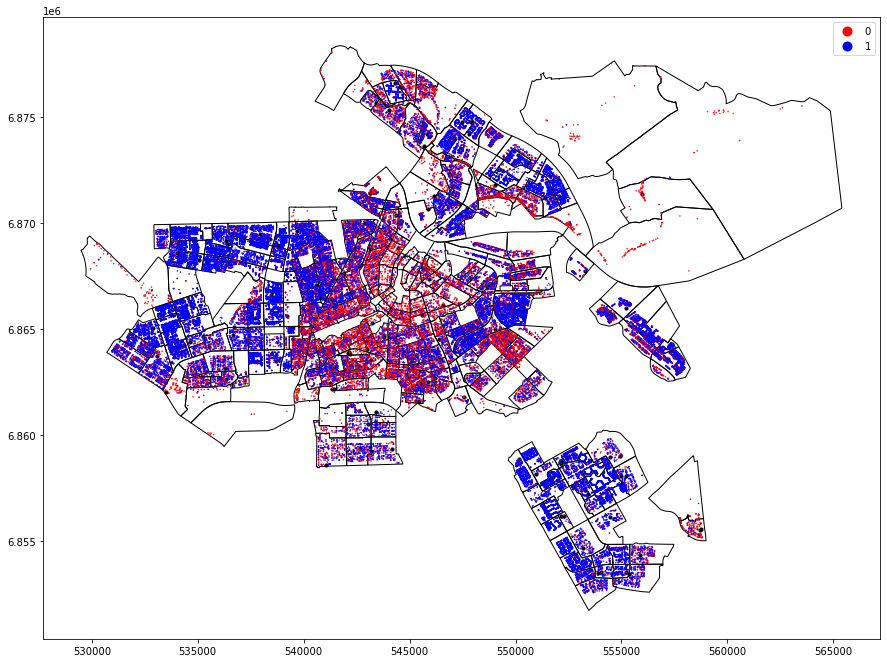

In [21]:
fig, ax = plt.subplots(1, 1, figsize=(15, 15))
neighbourhood_frame.geometry.boundary.plot(
    color=None, edgecolor='k', 
    linewidth=1, ax=ax, zorder=1)
school_frame.plot(ax=ax, color='black', markersize=10)

cmap = colors.ListedColormap(['red', 'blue'])

_ = household_frame.plot(
            ax=ax, markersize=0.25, categorical=True, column='group',
            cmap=cmap, legend=True)

In [22]:
# Calculate distances
distances = household_frame.geometry.apply(lambda houselold: school_frame.distance(houselold))

In [29]:
school_frame

,geometry,Buurt_code,shape,size,color
0,POINT (545577.414 6865636.197),None,circle,5,black
1,POINT (544187.691 6859338.533),None,circle,5,black
2,POINT (542104.269 6863857.630),None,circle,5,black
3,POINT (547901.142 6865148.543),None,circle,5,black
4,POINT (534603.357 6869637.007),None,circle,5,black
...,...,...,...,...,...
199,POINT (557384.906 6864272.578),None,circle,5,black
200,POINT (542980.420 6864501.038),None,circle,5,black
201,POINT (541519.530 6863235.668),None,circle,5,black
202,POINT (541324.642 6862153.595),None,circle,5,black


### Save the data in GeoJSON format

In [14]:
path = 'amsterdam/' 
neighbourhood_frame.to_file(path + "neighbourhoods.geojson")
school_frame.to_file(path + "schools.geojson")
household_frame.to_file(path + "households.geojson")
np.savez_compressed(path + 'distances_perc_of_actual.npz', 
                    distances=distances.to_numpy(), 
                    perc_of_actual=perc_of_actual)